In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN

from statsmodels.formula.api import ols
import statsmodels.api as sm

In [2]:
df = pd.read_csv('crop_yield.csv')
df.head()

,Crop,Precipitation,SpecificHumidity_g_kg,RelativeHumidity_%,Temperature_C,Yield
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800


### Análise Exploratória

In [3]:
df.shape

(156, 6)

Não temos dados ausentes.

Temos um campo categórico (Crop)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Crop                   156 non-null    object 
 1   Precipitation          156 non-null    float64
 2   SpecificHumidity_g_kg  156 non-null    float64
 3   RelativeHumidity_%     156 non-null    float64
 4   Temperature_C          156 non-null    float64
 5   Yield                  156 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 7.4+ KB


In [5]:
df.describe()

,Precipitation,SpecificHumidity_g_kg,RelativeHumidity_%,Temperature_C,Yield
count,156.000000,156.000000,156.000000,156.00000,156.000000
mean,2486.498974,18.203077,84.737692,26.18359,56153.096154
std,289.457914,0.293923,0.996226,0.26105,70421.958897
min,1934.620000,17.540000,82.110000,25.56000,5249.000000
25%,2302.990000,18.030000,84.120000,26.02000,8327.750000
50%,2424.550000,18.270000,84.850000,26.13000,18871.000000
75%,2718.080000,18.400000,85.510000,26.30000,67518.750000
max,3085.790000,18.700000,86.100000,26.81000,203399.000000


array([[<Axes: title={'center': 'Precipitation'}>,
        <Axes: title={'center': 'SpecificHumidity_g_kg'}>],
       [<Axes: title={'center': 'RelativeHumidity_%'}>,
        <Axes: title={'center': 'Temperature_C'}>],
       [<Axes: title={'center': 'Yield'}>, <Axes: >]], dtype=object)

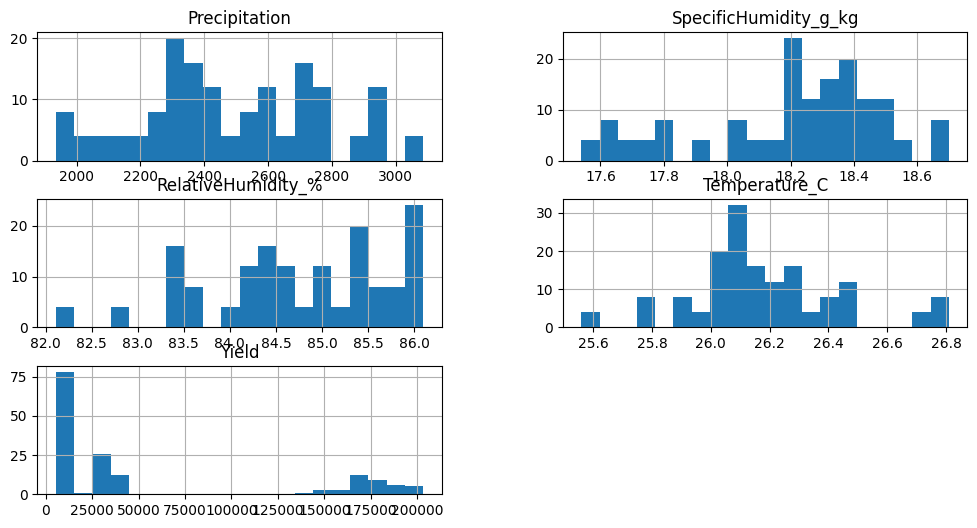

In [6]:
df.hist(bins=20, figsize=(12,6))

Correlação das variáveis

Aparentemente, nenhuma das variáveis tem uma correlação forte (negativamente ou positivamente) com a variável alvo (Yield). Isto pode signficar que **a relação entre as variáveis não estejam de forma linear**.

<Axes: >

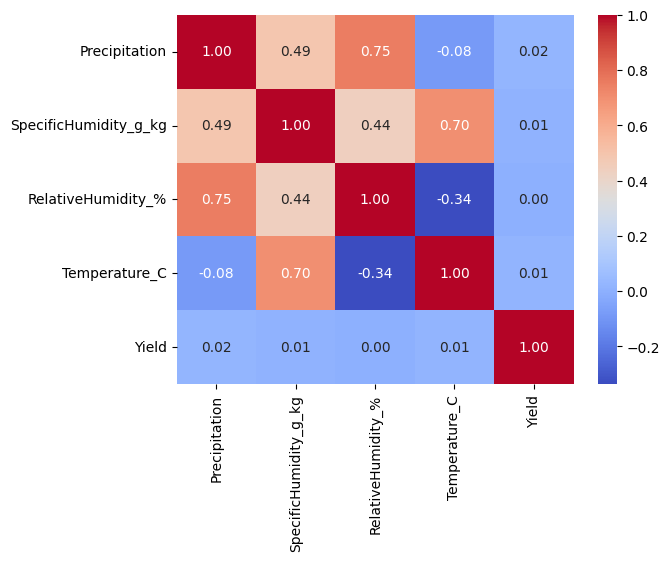

In [7]:
corr = df.corr(numeric_only=True)

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')

Boxplots para visualizar a distribuição dos valores das variáveis e verificar a presença de outliers.

É possível visualizar outliers em temperatura e rendimento, porém, por enquanto iremos manter esses dados.

Porém, temos muitos outliers na coluna *Yield*, algo que pode **ocasionar problemas na generalização do modelo**.

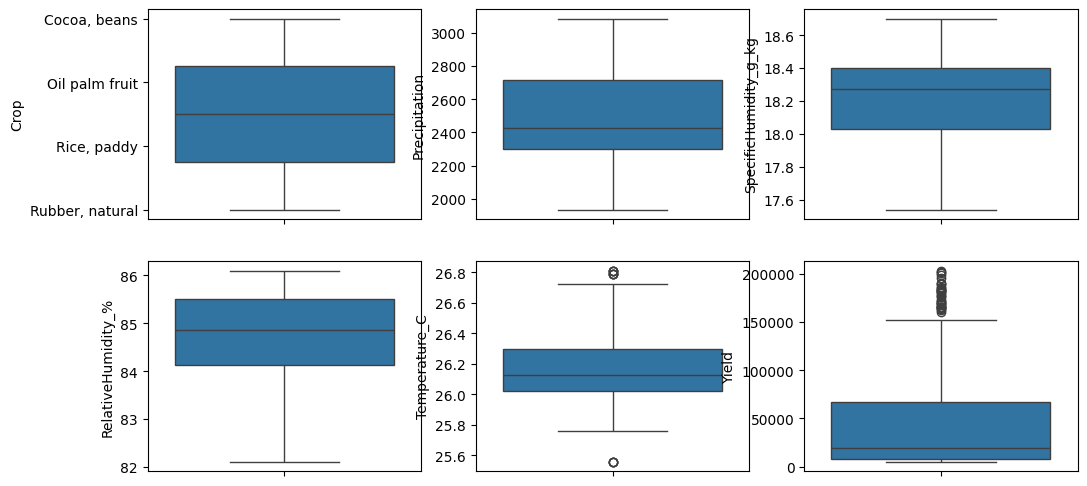

In [8]:
plt.figure(figsize=(12,6))
for i in range(0, len(df.columns)):
    plt.subplot(2,3, i+1)
    sns.boxplot(df[df.columns[i]])

Visualização das 2 variáveis com outliers (Temperatura e Rendimento).

<Axes: ylabel='Temperature_C'>

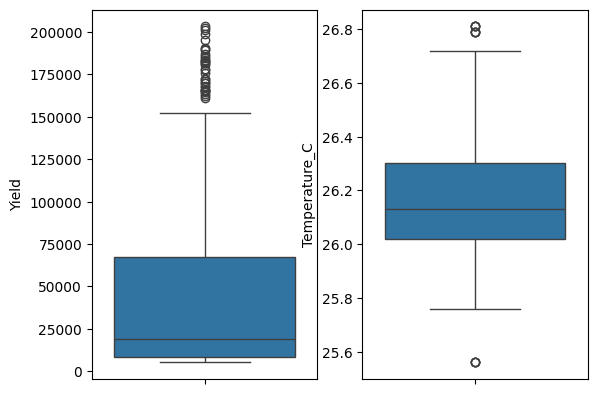

In [9]:
plt.subplot(1,2,1)
sns.boxplot(df['Yield'])
plt.subplot(1,2,2)
sns.boxplot(df['Temperature_C'])

Gráfico de dispersão para visualizar os agrupamentos de rendimentos baseada na cultura (Crop).

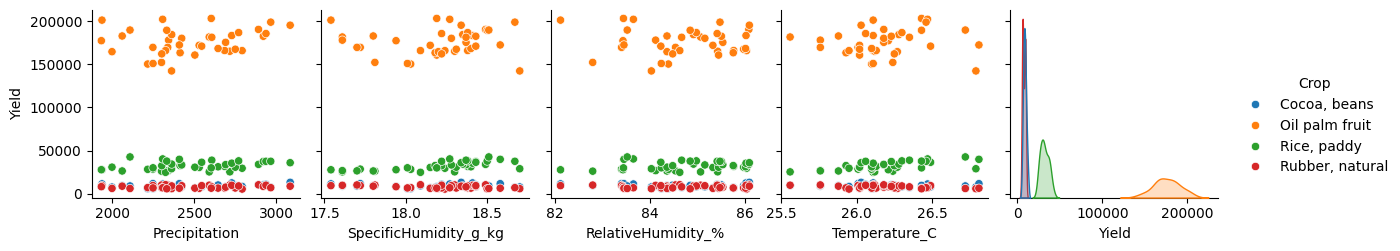

In [10]:
sns.pairplot(df, y_vars='Yield', hue='Crop')

Gráficos de dispersão para observar o agrupamento de rendimento (Yield) baseado na própria Yield, o gráfico irá realizar alguns agrupamentos pelo valor de rendimento.

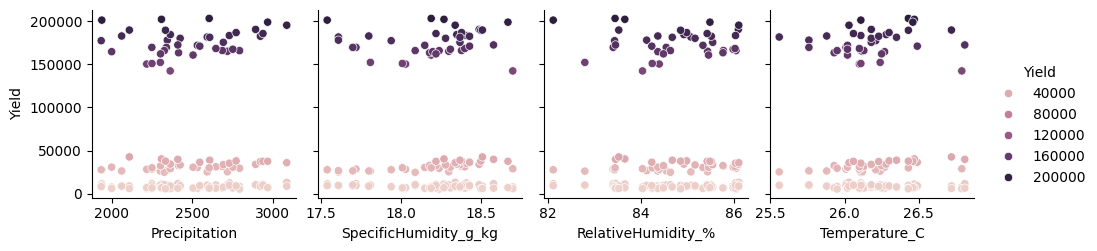

In [11]:
sns.pairplot(df, y_vars='Yield', hue='Yield')

Através da observação do padrão existente das variáveis dependentes com a coluna Yield, é possível observar que os dados podem estar agrupados em diferentes *faixas de rendimento*, ao invés de seguir uma relação linear direta com as variáveis climáticas.

Uma das possibilidades interessantes é que o rendimento pode estar sendo segmentado por categorias ocultas (clusters). Talvez possamos observar estes agrupamentos através da variável categórica "Crop".

Fazendo o tratamento da coluna categórica "Crop" com One-Hot Encoding:

In [12]:
df = pd.get_dummies(df, columns=['Crop'], drop_first=True) # Drop First para evitar a multicolinearidade (variaveis redundantes)
df.head()

,Precipitation,SpecificHumidity_g_kg,RelativeHumidity_%,Temperature_C,Yield,Crop_Oil palm fruit,"Crop_Rice, paddy","Crop_Rubber, natural"
0,2248.92,17.72,83.40,26.01,11560,False,False,False
1,1938.42,17.54,82.11,26.11,11253,False,False,False
2,2301.54,17.81,82.79,26.24,9456,False,False,False
3,2592.35,17.61,85.07,25.56,9321,False,False,False
4,2344.72,17.61,84.12,25.76,8800,False,False,False


Utilizaremos um algoritmo de clusterização (DBSCAN) para visualizar se é retornado os mesmos agrupamentos, porém antes, será necessário realizar uma normalização dos valores numéricos. Estamos utilizando normalização para manter a mesma escala entre os dados.

In [13]:
normalization = MinMaxScaler()
X_normalized = normalization.fit_transform(df)

In [14]:
#dbscan = DBSCAN(eps=0.4, min_samples=3)
dbscan = DBSCAN()

dbscan_result = dbscan.fit_predict(X_normalized)
dbscan_result

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3])

In [15]:
df_tests = df.copy()
df_tests['cluster_predicted'] = dbscan_result

Ao fazer o one-hot encoding da variável categórica "Crop", o algoritmo de clusterização DBSCAN conseguiu segmentar a maior parte dos dados de acordo com a distribuição da variável "Yield". Assim como, o algoritmo não encontrou presença de *outliers* no dataset.

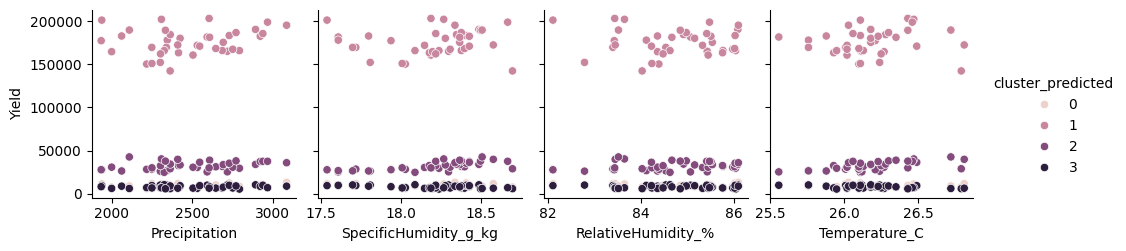

In [16]:
sns.pairplot(df_tests, y_vars='Yield', x_vars=['Precipitation','SpecificHumidity_g_kg', 'RelativeHumidity_%', 'Temperature_C'], hue='cluster_predicted')

No gráfico abaixo, é possível observar que o tratamento da coluna categórica "Crop" com One-Hot Encoding resultou em correlações significativas com a variável alvo (Yield).

**Nota (Por que não funcionou com LabelEncoder)?**

Foi testado um tratamento diferente desta coluna, no caso, com Label Encoder (onde transformou os dados categóricos em numéricos), porém não havia sido possível adquirir uma correlação significativa com a variável alvo.

**LabelEncoder:** Ideal usar quando a variável categórica tem **ordem natural**/ordinal (exemplo: "baixo, médio, alto" ou "pequeno, médio, grande"). A coluna "Crop" não tem esse tipo de significado.

**One-Hot-Encoding**: Ideal quando a variável **não tem ordem** e cada categoria representa um grupo distinto (exemplo: tipos de culturas, cores de carros, nomes de cidades).

<Axes: >

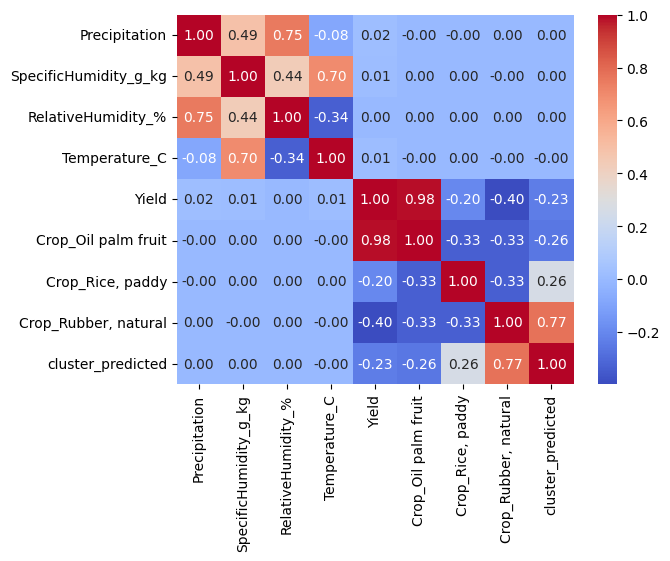

In [17]:
corr = df_tests.corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')

### Analisando as relações entre as variáveis com Statsmodel

Removendo espaços e caracteres especiais nas colunas categóricas.

In [18]:
df.rename(columns=lambda x: x.replace(' ', '').replace(',', ''), inplace=True)
df.head()

,Precipitation,SpecificHumidity_g_kg,RelativeHumidity_%,Temperature_C,Yield,Crop_Oilpalmfruit,Crop_Ricepaddy,Crop_Rubbernatural
0,2248.92,17.72,83.40,26.01,11560,False,False,False
1,1938.42,17.54,82.11,26.11,11253,False,False,False
2,2301.54,17.81,82.79,26.24,9456,False,False,False
3,2592.35,17.61,85.07,25.56,9321,False,False,False
4,2344.72,17.61,84.12,25.76,8800,False,False,False


**Testando Regressão Linear Simples**

Prever Yield baseada na Crop_Oilpalmfruit (relação entre Yield e Crop_Oilpalmfruit).

In [19]:
model_1 = ols('Yield ~ Crop_Oilpalmfruit', data=df).fit()

In [20]:
model_1.params

Intercept                     16269.230769
Crop_Oilpalmfruit[T.True]    159535.461538
dtype: float64

In [21]:
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Yield   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     4732.
Date:                Sun, 02 Mar 2025   Prob (F-statistic):          1.59e-117
Time:                        10:22:43   Log-Likelihood:                -1692.5
No. Observations:                 156   AIC:                             3389.
Df Residuals:                     154   BIC:                             3395.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

**Testando Regressão Linear Multipla**

Prever Yield baseada nas colunas categóricas (todas).

Podemos observar que especificamente a variável RubberNatural, por algum motivo tem o valor de *p-value* maior do que 0.05 (5%), ou seja, **pode ser que esta variável não tem um impacto estatisticamente significativo na variável alvo**.

Porém, temos 4 tipos de categorias (apenas 3 na coluna para não haver multicolinearidade), então, iremos manter essa variável no modelo, mesmo que pareça não ser estatisticamente significativo.

In [22]:
model_2 = ols('Yield ~ Crop_Oilpalmfruit + Crop_Ricepaddy + Crop_Rubbernatural', data=df).fit()
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Yield   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     4030.
Date:                Sun, 02 Mar 2025   Prob (F-statistic):          1.36e-144
Time:                        10:22:43   Log-Likelihood:                -1619.8
No. Observations:                 156   AIC:                             3248.
Df Residuals:                     152   BIC:                             3260.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

### Analisando os resíduos

In [23]:
normalization = MinMaxScaler()
X_normalized = normalization.fit_transform(df[['Crop_Oilpalmfruit','Crop_Ricepaddy', 'Crop_Rubbernatural']])

# É necessário transformar os dados em um dataframe para passar o modelo do statsmodels
df_X_train = pd.DataFrame(X_normalized, columns=['Crop_Oilpalmfruit', 'Crop_Ricepaddy', 'Crop_Rubbernatural'])
df_X_train.head()

,Crop_Oilpalmfruit,Crop_Ricepaddy,Crop_Rubbernatural
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


Previsão dos valores de treino (dataset inteiro) apenas para verificar se o modelo está se ajustando bem aos dados.

In [24]:
model_y_predicts = model_2.predict(df_X_train)

**Análise dos Resíduos**

É possível observar que a previsão do modelo se concentrou em 4 áreas, porém, o **motivo disto deve ser pelo fato de que não consideramos humidade, temperatura e precipitação**, apenas as categorias, portanto, seria interessante também adicionar essas informações.

Text(0, 0.5, 'Resíduos')

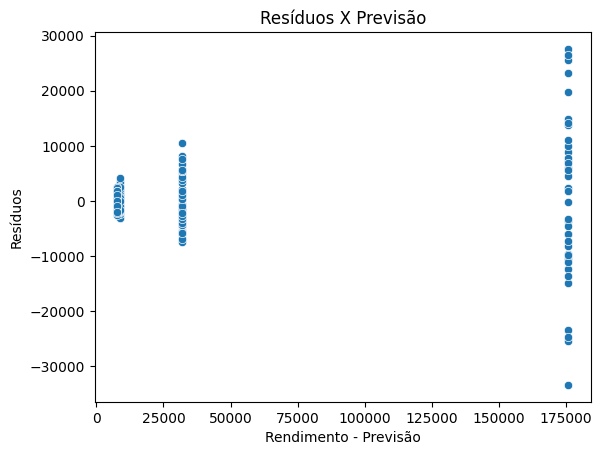

In [25]:
sns.scatterplot(x=model_y_predicts, y=model_2.resid)
plt.title('Resíduos X Previsão')
plt.xlabel('Rendimento - Previsão')
plt.ylabel('Resíduos')

### Melhorando o modelo com os dados de humidade, temperatura e precipitação

Iremos realizar um teste de um modelo com todas as informações (exceto, Yield).

In [26]:
# Separando caracteristicas dos rótulos
X = df.drop('Yield', axis=1)
y = df['Yield']

normalization = MinMaxScaler()
X_scaled = normalization.fit_transform(X)

df_X_scaled = pd.DataFrame(X_scaled, columns=df.drop('Yield', axis=1).columns)

# Necessário adicionar um valor de constante, para permitir ao modelo encontrar um valor de y quando x = 0 (intercepto)
df_X_scaled = sm.add_constant(df_X_scaled)
df_X_scaled.head()

,const,Precipitation,SpecificHumidity_g_kg,RelativeHumidity_%,Temperature_C,Crop_Oilpalmfruit,Crop_Ricepaddy,Crop_Rubbernatural
0,1.0,0.273027,0.155172,0.323308,0.360,0.0,0.0,0.0
1,1.0,0.003301,0.000000,0.000000,0.440,0.0,0.0,0.0
2,1.0,0.318737,0.232759,0.170426,0.544,0.0,0.0,0.0
3,1.0,0.571358,0.060345,0.741855,0.000,0.0,0.0,0.0
4,1.0,0.356246,0.060345,0.503759,0.160,0.0,0.0,0.0


Aparentemente o modelo criado não "notou" a multicolinearidade entre as variáveis de humidade relativa e específica, porém mesmo assim, iremos realizar uma **combinação de features** das mesmas.

In [27]:
model_3 = sm.OLS(y, df_X_scaled).fit()
print(model_3.summary())

                            OLS Regression Results                            
Dep. Variable:                  Yield   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     1818.
Date:                Sun, 02 Mar 2025   Prob (F-statistic):          4.35e-140
Time:                        10:22:43   Log-Likelihood:                -1613.8
No. Observations:                 156   AIC:                             3244.
Df Residuals:                     148   BIC:                             3268.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  5.406e+

Combinação de features das 2 variáveis de humidade.

In [28]:
X['humidity_combined'] = X['RelativeHumidity_%'] * X['SpecificHumidity_g_kg'] # Combinação das features

X.drop(['SpecificHumidity_g_kg', 'RelativeHumidity_%'], axis=1, inplace=True) # Excluindo valores de humidade anteriores

Novamente, iremos normalizar o dataset, agora com as features combinadas.

In [29]:
normalization = MinMaxScaler()
X_scaled = normalization.fit_transform(X)

df_X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
df_X_scaled.drop(['Crop_Rubbernatural','Temperature_C'], axis=1, inplace=True)

# Necessário adicionar um valor de constante, para permitir ao modelo encontrar um valor de y quando x = 0 (intercepto)
df_X_scaled = sm.add_constant(df_X_scaled)
df_X_scaled.head()

,const,Precipitation,Crop_Oilpalmfruit,Crop_Ricepaddy,humidity_combined
0,1.0,0.273027,0.0,0.0,0.241735
1,1.0,0.003301,0.0,0.0,0.000000
2,1.0,0.318737,0.0,0.0,0.220167
3,1.0,0.571358,0.0,0.0,0.371692
4,1.0,0.356246,0.0,0.0,0.264247


In [30]:
model_4 = sm.OLS(y, df_X_scaled).fit()
print(model_4.summary())

                            OLS Regression Results                            
Dep. Variable:                  Yield   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     3095.
Date:                Sun, 02 Mar 2025   Prob (F-statistic):          9.76e-144
Time:                        10:22:43   Log-Likelihood:                -1617.5
No. Observations:                 156   AIC:                             3245.
Df Residuals:                     151   BIC:                             3260.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              6753.2799   1976.85

In [31]:
model_4_y_predicts = model_4.predict(df_X_scaled)

No gráfico de resíduos abaixo, assim como no anterior, é um forte indício de **heterocedasticidade**, pelo fato de que os resíduos do modelo não estão distribuídos de forma aleatória, mas sim seguem um padrão específico. Isso pode indicar que **o modelo linear não está captando corretamente a estrutura dos dados**. Portanto, seria interessante testar modelos **não lineares** para este contexto, como uma Floresta Aleatória, XGBoost ou Redes Neurais.

Text(0, 0.5, 'Resíduos')

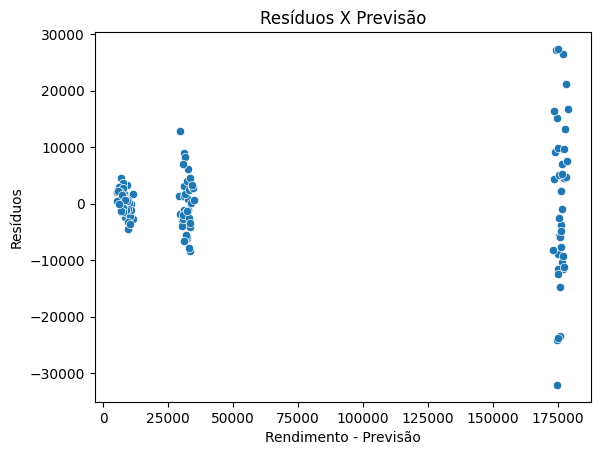

In [32]:
sns.scatterplot(x=model_4_y_predicts, y=model_4.resid)
plt.title('Resíduos X Previsão')
plt.xlabel('Rendimento - Previsão')
plt.ylabel('Resíduos')

Iremos visualizar o gráfico de resíduos por faixa de rendimento para ter uma visão mais profunda dos resíduos para cada agrupamento de cultura.

In [33]:
df_resid = pd.DataFrame({
    'predict': model_4_y_predicts,
    'resid': model_4.resid,
    'Crop_Oilpalmfruit': df_X_scaled['Crop_Oilpalmfruit'],
    'Crop_Ricepaddy': df_X_scaled['Crop_Ricepaddy']
})
df_resid.head()

,predict,resid,Crop_Oilpalmfruit,Crop_Ricepaddy
0,8024.105230,3535.894770,0.0,0.0
1,6776.548129,4476.451871,0.0,0.0
2,8404.631175,1051.368825,0.0,0.0
3,9775.566688,-454.566688,0.0,0.0
4,8549.831003,250.168997,0.0,0.0


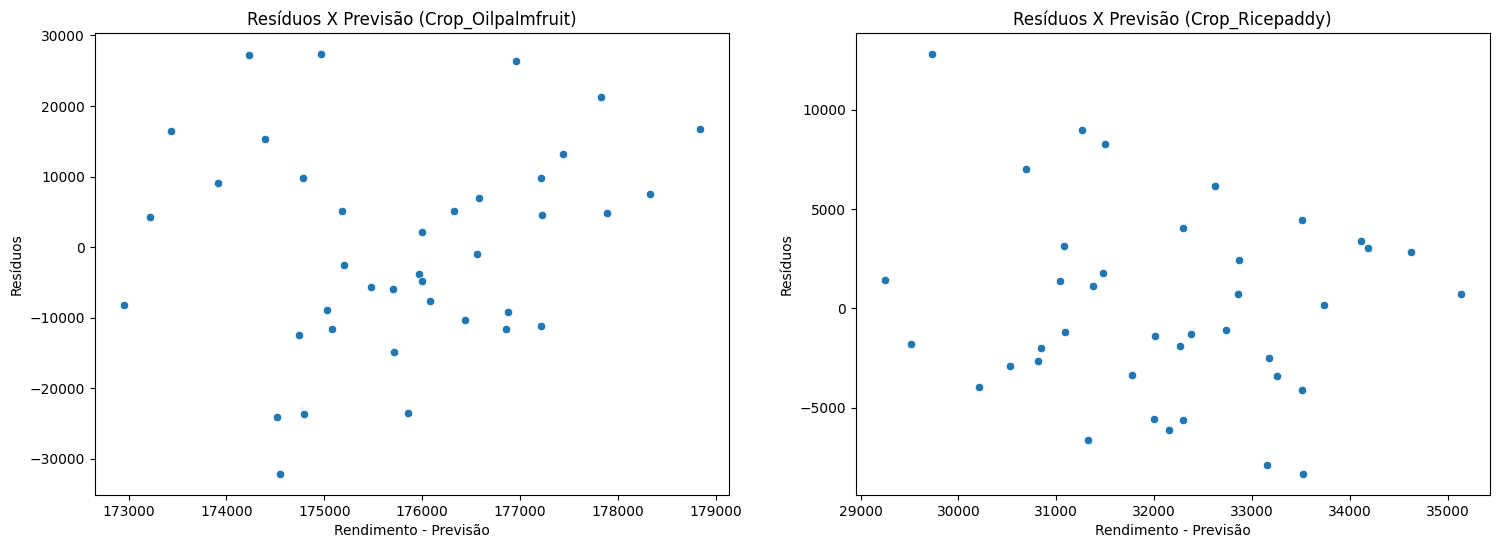

In [34]:
fig, axes = plt.subplots(1,2, figsize=(18,6))

crop_labels = ['Crop_Oilpalmfruit', 'Crop_Ricepaddy']
for idx, crop in enumerate(crop_labels):
    sns.scatterplot(x=df_resid['predict'][df_resid[crop] == True],
                    y=df_resid['resid'][df_resid[crop] == True],
                    ax=axes[idx])
    
    axes[idx].set_title(f'Resíduos X Previsão ({crop})')
    axes[idx].set_xlabel('Rendimento - Previsão')
    axes[idx].set_ylabel('Resíduos')

O gráfico de resíduos na situação onde não é OilPalmFruit e nem Ricepaddy.

Aqui temos 2 residuos agrupados pois temos quatro culturas, e não somente duas, porém para o modelo conseguir convergir, foi concluído que apenas Rice paddy e Oil Palm Fruit são o suficiente.

Text(0, 0.5, 'Resíduos')

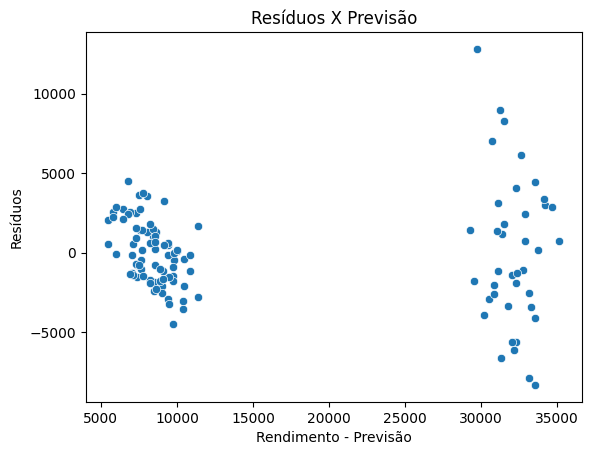

In [35]:
sns.scatterplot(x=df_resid['predict'][(df_resid['Crop_Oilpalmfruit']) == False & (df_resid['Crop_Ricepaddy'] == False)],
                    y=df_resid['resid'][(df_resid['Crop_Oilpalmfruit']) == False & (df_resid['Crop_Ricepaddy'] == False)])
plt.title('Resíduos X Previsão')
plt.xlabel('Rendimento - Previsão')
plt.ylabel('Resíduos')